In [2]:
!pip install numpy torch

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajat95gupta/smartphone-image-denoising-dataset")
path = path + "/SIDD_Small_sRGB_Only" + "/Data"

print("Path to image files:", path)

Path to image files: /root/.cache/kagglehub/datasets/rajat95gupta/smartphone-image-denoising-dataset/versions/1/SIDD_Small_sRGB_Only/Data


In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

In [6]:
def create_dataset():
  data = []
  for filename in os.listdir(path):
    gt_path = None
    noisy_path = None
    for f in os.listdir(os.path.join(path, filename)):
        if f.startswith('GT_'):
            gt_path = os.path.join(path,filename, f)

        elif f.startswith('NOISY_'):
            noisy_path = os.path.join(path, filename, f)

    data.append({'gt':gt_path, 'noisy':noisy_path})

  return data

In [7]:
from PIL import Image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        gt_path = self.data[idx]['gt']
        noisy_path = self.data[idx]['noisy']
        gt = Image.open(gt_path)
        noisy = Image.open(noisy_path)
        if self.transform:
            gt = self.transform(gt)
            noisy = self.transform(noisy)
        return gt, noisy


In [8]:
NUM_TRAIN = 144
TARGET_SIZE = (400, 400)  # Example: Resize to 224x224 pixels

data = create_dataset()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(TARGET_SIZE),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

train = CustomImageDataset(data, transform=transform)
loader_train = DataLoader(train, batch_size=4,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomImageDataset(data, transform=transform)
loader_val = DataLoader(val, batch_size=4,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 160)))

test = CustomImageDataset(data, transform=transform)
loader_test = DataLoader(test, batch_size=4)

Show sample images from training set

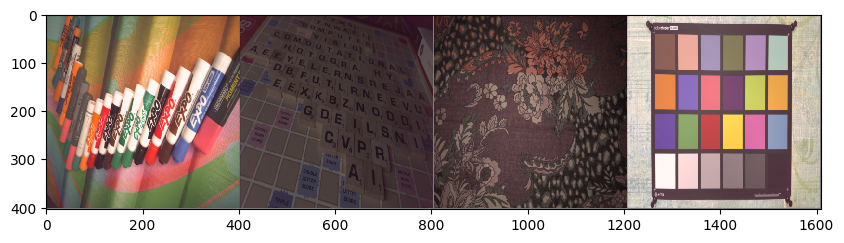

In [9]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(loader_train)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [10]:
def flatten(x, start_dim=1, end_dim=-1):
  return x.view(-1)

In [11]:
dtype = torch.float
ltype = torch.long

def check_accuracy(loader, model):
    if hasattr(loader.dataset, 'train') and loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')

    num_correct = 0
    num_samples = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move inputs to device
            y = y.to(device=device, dtype=ltype)  # Ensure y is integer type for classification

            # Process y if it is one-hot encoded or has extra dimensions
            if len(y.shape) > 1:
                y = y.argmax(dim=1)  # Convert one-hot encoded y to class indices

            scores = model(x)  # Forward pass
            _, preds = scores.max(1)  # Get predicted class (index of max score)

            # Print debug info
            print(f"Preds shape: {preds.shape}, y shape: {y.shape}")

            preds = flatten(preds)
            y = flatten(y)

            print(f"Preds shap after flatteninge: {preds.shape}," +
                  f"y shape after flattening: {y.shape}")

            # Compare predictions with ground truth
            num_correct += (preds == y).sum().item()  # Count correct predictions
            num_samples += preds.size(0)  # Update total samples

        acc = float(num_correct) / num_samples  # Calculate accuracy
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

In [25]:
# Constant to control how frequently we print train loss
print_every = 100
loss_function = nn.MSELoss()

def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Accuracy History, also prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)

  for e in range(epochs):

    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training modeq
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=dtype)

      scores = model(x)
      #print(f"Shape of scores: {scores.shape}, dtype: {scores.dtype}")
      #print(f"Shape of y:{y.shape}, dtype: {y.dtype}")

      loss = loss_function(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

Denoising Model

In [32]:
class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)

class Reshape(nn.Module):
  def forward(self, x):
    return torch.reshape(x, [128,50,50])

def block(in_dim, out_dim, width):
    return nn.Sequential(
        nn.Conv2d(in_dim, in_dim, 1+2*width, padding=width),
        nn.BatchNorm2d(in_dim),
        nn.ReLU(),
        nn.Conv2d(in_dim, in_dim, 1+2*width, padding=width),
        nn.BatchNorm2d(in_dim),
        nn.ReLU(),
    )

class ConvResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, width):
        super().__init__()
        self.block = block(in_dim, out_dim, width)
        self.conv = nn.Conv2d(in_dim, out_dim, 1+2*width, padding=width)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.m = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = x + self.block(x)
        x = self.conv(x)
        x = self.m(x)

        return x

class TransConvResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, width):
      super().__init__()
      self.block = block(in_dim, out_dim, width)
      self.conv = nn.Conv2d(in_dim, out_dim, 1+2*width, padding=width)
      self.in_dim = in_dim
      self.out_dim = out_dim
      self.d = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2)

    def forward(self, x):
      x = x + self.block(x)
      x = self.d(x)

      return x

learning_rate = 4e-3
weight_decay = 1e-3
momentum = 0.9

model = None
optimizer = None

# model = nn.Sequential(
#     nn.Conv2d(3, 16, 3, padding=1), # (B,16,400,400)
#     ConvResBlock(16, 32, 1), # (B,32,200,200)
#     nn.Dropout(),
#     ConvResBlock(32, 64, 1), # (B,64,100,100)
#     nn.Dropout(),
#     ConvResBlock(64, 128, 1), # (B,128,50,50)
#     # Flatten(), # (B, 128*50*50)
#     # nn.Linear(128*50*50, 128*50*50),
#     # nn.ReLU(),
#     # Reshape(), # (B,128,50,50)
#     TransConvResBlock(128, 64, 1), # (B, 64, 100, 100)
#     TransConvResBlock(64, 32, 1), # (B, 32, 200, 200)
#     TransConvResBlock(32, 16, 1), # (B, 16, 400, 400)
#     nn.Conv2d(16, 3, 3, padding=1) # (B, 3, 400, 400)
# )

model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1), # (B,16,400,400)
    ConvResBlock(16, 32, 1), # (B,32,200,200)
    nn.Dropout(),
    ConvResBlock(32, 64, 1), # (B,64,100,100)
    nn.Dropout(),
    ConvResBlock(64, 128, 1), # (B,128,50,50)
    nn.Upsample(scale_factor=2, mode='nearest'), # (B, 128, 100, 100)
    nn.Conv2d(128, 64, 3, padding=1), # (B, 64, 100, 100)
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(32, 3, 3, padding=1),
)

model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

# You should get at least 70% accuracy
train(model, optimizer)


Epoch 0, Iteration 0, loss = 0.3856
Checking accuracy on test set
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape after flattening: torch.Size([640000])
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape after flattening: torch.Size([640000])
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape after flattening: torch.Size([640000])
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape after flattening: torch.Size([640000])
Got 2268425 / 2560000 correct (88.61%)

Epoch 0, Iteration 35, loss = 0.6744
Checking accuracy on test set
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape a

(tensor([0.0083]), tensor([35]))

x:  tensor([[[0.2205, 0.0971, 0.0669,  ..., 0.0709, 0.1053, 0.2429],
         [0.1031, 0.0262, 0.0125,  ..., 0.0160, 0.0337, 0.1454],
         [0.0584, 0.0091, 0.0036,  ..., 0.0045, 0.0112, 0.0840],
         ...,
         [0.0779, 0.0159, 0.0067,  ..., 0.0049, 0.0117, 0.0849],
         [0.1301, 0.0404, 0.0195,  ..., 0.0144, 0.0294, 0.1326],
         [0.2536, 0.1370, 0.0922,  ..., 0.0758, 0.1142, 0.2488]],

        [[0.2184, 0.1240, 0.0805,  ..., 0.0895, 0.1344, 0.2628],
         [0.0706, 0.0174, 0.0072,  ..., 0.0091, 0.0218, 0.1133],
         [0.0501, 0.0083, 0.0033,  ..., 0.0040, 0.0103, 0.0850],
         ...,
         [0.0972, 0.0169, 0.0075,  ..., 0.0050, 0.0113, 0.0927],
         [0.1283, 0.0302, 0.0143,  ..., 0.0097, 0.0209, 0.1200],
         [0.3092, 0.1634, 0.1237,  ..., 0.0935, 0.1224, 0.2756]],

        [[0.2224, 0.0851, 0.0647,  ..., 0.0661, 0.0946, 0.2302],
         [0.0923, 0.0136, 0.0065,  ..., 0.0063, 0.0147, 0.0874],
         [0.0605, 0.0056, 0.0025,  ..., 0.0023, 0.0059

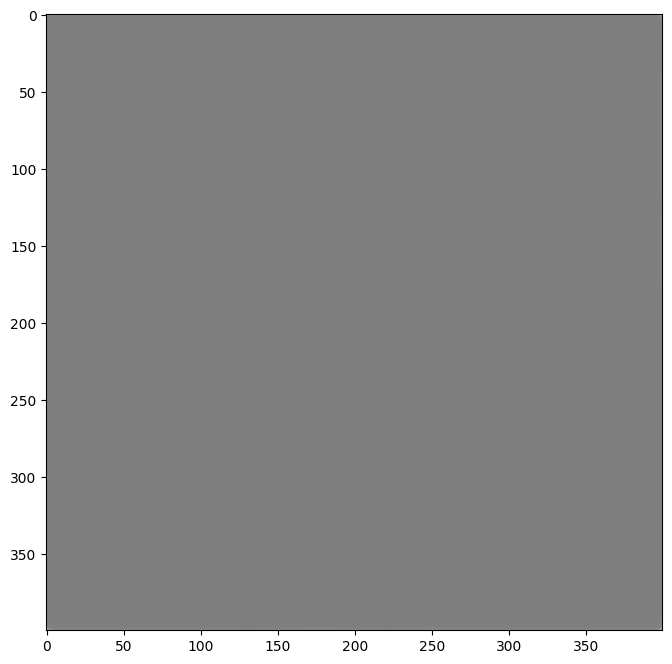

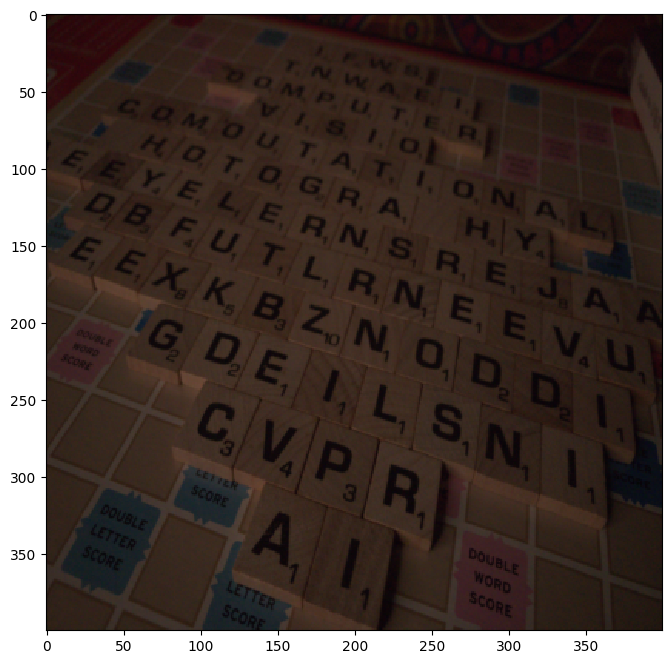

x:  tensor([[[0.2426, 0.1195, 0.0874,  ..., 0.0782, 0.1140, 0.2518],
         [0.1241, 0.0380, 0.0201,  ..., 0.0189, 0.0387, 0.1552],
         [0.0755, 0.0149, 0.0067,  ..., 0.0057, 0.0136, 0.0925],
         ...,
         [0.0595, 0.0098, 0.0036,  ..., 0.0047, 0.0113, 0.0837],
         [0.1078, 0.0284, 0.0122,  ..., 0.0139, 0.0286, 0.1310],
         [0.2313, 0.1137, 0.0710,  ..., 0.0743, 0.1125, 0.2471]],

        [[0.2398, 0.1471, 0.1016,  ..., 0.0978, 0.1437, 0.2715],
         [0.0900, 0.0264, 0.0125,  ..., 0.0111, 0.0256, 0.1227],
         [0.0665, 0.0138, 0.0062,  ..., 0.0051, 0.0125, 0.0935],
         ...,
         [0.0759, 0.0103, 0.0041,  ..., 0.0048, 0.0110, 0.0915],
         [0.1042, 0.0199, 0.0085,  ..., 0.0093, 0.0203, 0.1183],
         [0.2853, 0.1352, 0.0978,  ..., 0.0918, 0.1205, 0.2736]],

        [[0.2436, 0.1059, 0.0837,  ..., 0.0730, 0.1027, 0.2392],
         [0.1126, 0.0210, 0.0110,  ..., 0.0078, 0.0175, 0.0958],
         [0.0777, 0.0096, 0.0048,  ..., 0.0030, 0.0074

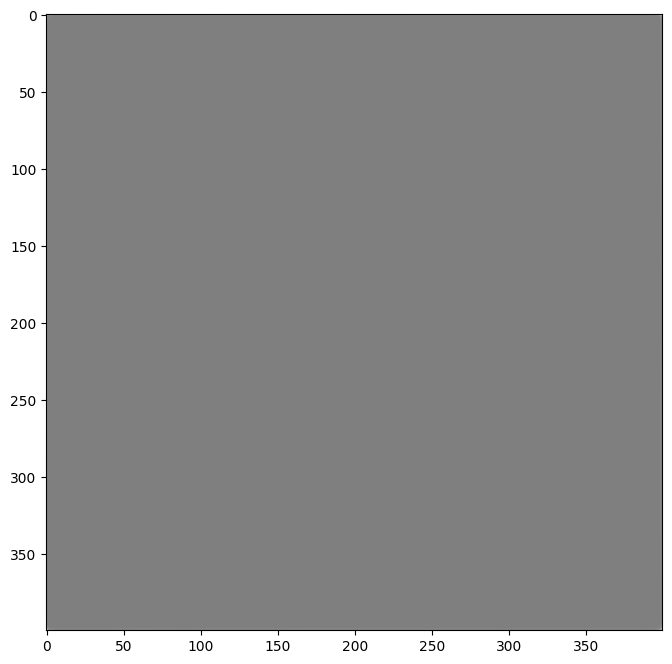

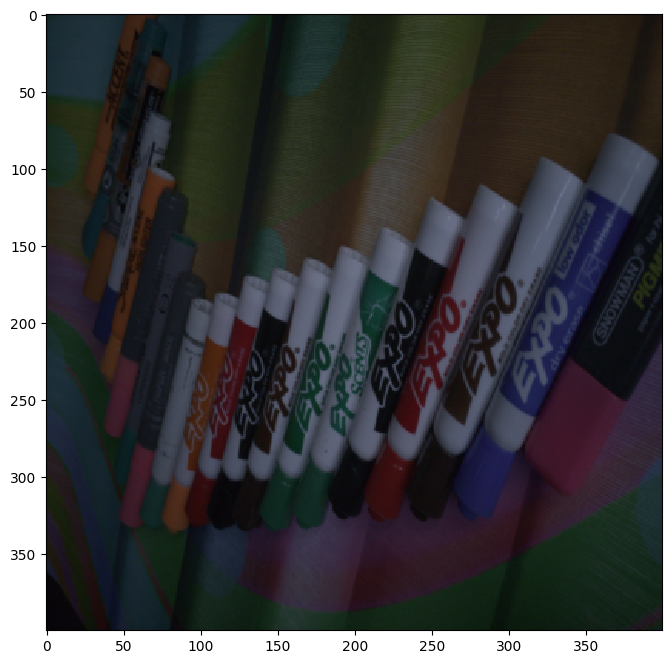

x:  tensor([[[0.2435, 0.1216, 0.0892,  ..., 0.1080, 0.1479, 0.2822],
         [0.1250, 0.0389, 0.0208,  ..., 0.0339, 0.0626, 0.1920],
         [0.0771, 0.0156, 0.0072,  ..., 0.0125, 0.0265, 0.1266],
         ...,
         [0.1084, 0.0285, 0.0138,  ..., 0.0103, 0.0217, 0.1135],
         [0.1648, 0.0622, 0.0338,  ..., 0.0258, 0.0476, 0.1657],
         [0.2840, 0.1714, 0.1241,  ..., 0.1043, 0.1463, 0.2787]],

        [[0.2406, 0.1482, 0.1031,  ..., 0.1284, 0.1767, 0.2994],
         [0.0912, 0.0270, 0.0128,  ..., 0.0211, 0.0429, 0.1581],
         [0.0686, 0.0144, 0.0065,  ..., 0.0112, 0.0240, 0.1273],
         ...,
         [0.1301, 0.0301, 0.0153,  ..., 0.0108, 0.0214, 0.1251],
         [0.1635, 0.0490, 0.0261,  ..., 0.0190, 0.0360, 0.1544],
         [0.3359, 0.1976, 0.1581,  ..., 0.1264, 0.1567, 0.3059]],

        [[0.2456, 0.1069, 0.0852,  ..., 0.1008, 0.1341, 0.2701],
         [0.1154, 0.0217, 0.0116,  ..., 0.0155, 0.0309, 0.1273],
         [0.0811, 0.0104, 0.0053,  ..., 0.0070, 0.0150

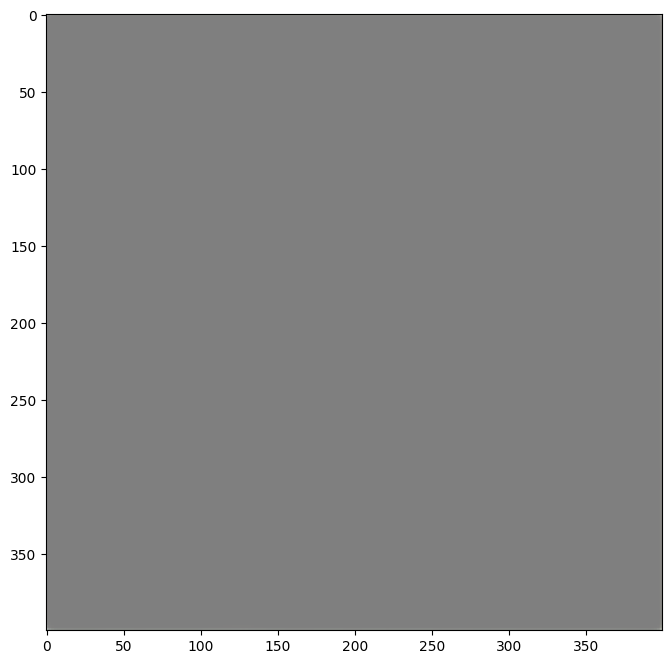

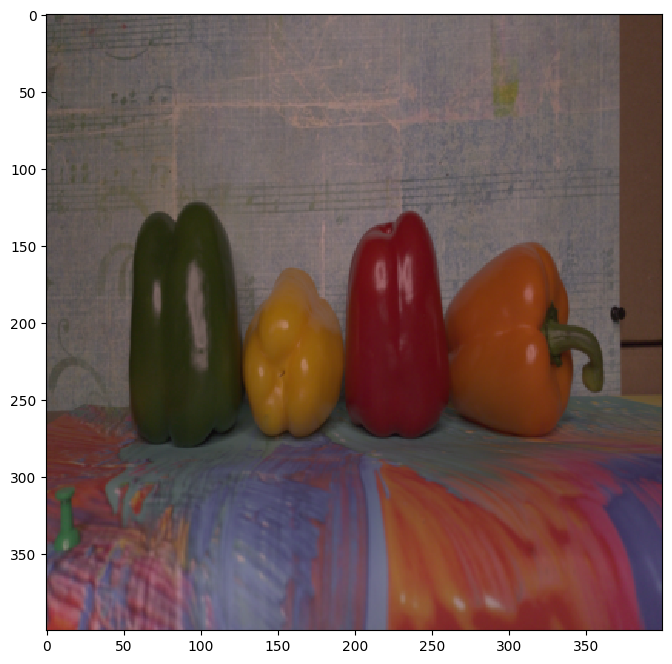

KeyboardInterrupt: 

In [31]:
model = model.to(device=device)

for t, (x, y) in enumerate(loader_test):

      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=dtype)

      scores = None

      with torch.no_grad():
        scores = model(x)

      print("x: ", scores[0, :, :, :])
      print("y: ", y[0, :, :, :])
      imshow(scores[0, :, :, :].cpu())
      imshow(y[0, :, :, :].cpu())